# Import dependencies

In [1]:
import numpy as np
# from Scripts.DataManager.DabasePreparations.AmazonReviewSentiGraph import AmazonReviewSentiGraph
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager
from Scripts.Configs.ConfigClass import Config
config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
from lightning.pytorch.loggers import CSVLogger
import os
# os.environ['TORCH_USE_CUDA_DSA']
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = 'cuda'
batch_size = 128

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchaudio\backend\utils.py:74: UserWarning: No audio backend is available.
  warnings.warn("No audio backend is available.")


# Load and prepare data

In [2]:
from Scripts.DataManager.GraphLoader.AmazonReviewGraphDataModule import AmazonReviewGraphDataModule

In [24]:
data_manager = AmazonReviewGraphDataModule(config, True, True, shuffle=True, num_data_load = -1, device='cpu', batch_size=batch_size)

self.num_data_load: 55000
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AmazonReview\graph_var.txt
 0 graph loaded
 100 graph loaded
 200 graph loaded
 300 graph loaded
 400 graph loaded
 500 graph loaded
 600 graph loaded
 700 graph loaded
 800 graph loaded
 900 graph loaded
 1000 graph loaded
 1100 graph loaded
 1200 graph loaded
 1300 graph loaded
 1400 graph loaded
 1500 graph loaded
 1600 graph loaded
 1700 graph loaded
 1800 graph loaded
 1900 graph loaded
 2000 graph loaded
 2100 graph loaded
 2200 graph loaded
 2300 graph loaded
 2400 graph loaded
 2500 graph loaded
 2600 graph loaded
 2700 graph loaded
 2800 graph loaded
 2900 graph loaded
 3000 graph loaded
 3100 graph loaded
 3200 graph loaded
 3300 graph loaded
 3400 graph loaded
 3500 graph loaded
 3600 graph loaded
 3700 graph loaded
 3800 graph loaded
 3900 graph loaded
 4000 graph loaded
 4100 graph loaded
 4200 graph loaded
 4300 graph loaded
 4400 graph loaded
 4500 graph loaded
 4600 graph loade

# Train Data

In [5]:
t_dataloader = data_manager.train_dataloader()
v_dataloader = data_manager.val_dataloader()

In [6]:
X1, y1 = next(iter(t_dataloader))
X2, y2 = next(iter(v_dataloader))
print(X1[0].x.device)
print(X2[0].x.device)

cpu
cpu


In [4]:
from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1

In [8]:
torch_model = GcnGatModel1(300, 1, 1024, dropout=0.2)
torch_model = torch_model.to(device)
# print(next(iter(torch_model.parameters())).device)
pre = torch_model(X1.to(device))

In [9]:
import torch
print("torch.cuda.memory_allocated: %fGB"%(torch.cuda.memory_allocated(0)/1024/1024/1024))
print("torch.cuda.memory_reserved: %fGB"%(torch.cuda.memory_reserved(0)/1024/1024/1024))
print("torch.cuda.max_memory_reserved: %fGB"%(torch.cuda.max_memory_reserved(0)/1024/1024/1024))

torch.cuda.memory_allocated: 1.950257GB
torch.cuda.memory_reserved: 2.736328GB
torch.cuda.max_memory_reserved: 2.736328GB


In [10]:
# from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from Scripts.Models.LightningModels.LightningModels import BinaryLightningModel
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner

In [11]:
callbacks = [
    ModelCheckpoint(save_top_k=2, mode='max', monitor='val_acc', save_last=True),
    EarlyStopping(patience=50, mode='max', monitor='val_acc')
]

In [12]:
lightning_model = BinaryLightningModel(torch_model,
                                 torch.optim.Adam(torch_model.parameters(), lr=0.00017, weight_decay=0.00055),
                                       torch.nn.BCEWithLogitsLoss(),
                                       learning_rate=0.00017,
                                       batch_size=batch_size,
                                       ).to(device)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


In [13]:
print(next(iter(torch_model.parameters())).device)
print(lightning_model.device)

cuda:0
cuda:0


In [14]:
# torch_model(X)

In [15]:
# t_dataloader = data_manager.train_dataloader()
# loss_func = torch.nn.BCEWithLogitsLoss()
# optimizer = torch.optim.Adam(torch_model.parameters(), 0.001, weight_decay=0.0055)
# for X,y in t_dataloader:
#     optimizer.zero_grad()
#     predicted = torch_model(X)
#     loss = loss_func(predicted, y)
#     loss.backward()
#     optimizer.step()

In [16]:
trainer = L.Trainer(
            callbacks=callbacks,
            max_epochs=5000,
            accelerator='gpu',
            logger=CSVLogger(save_dir='logs/', name='GcnGatSentiment3'),
            num_sanity_val_steps=0)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [17]:
# tuner = Tuner(trainer)
# results = tuner.lr_find(lightning_model, datamodule=data_manager, min_lr=0.00001,max_lr=0.03)

In [18]:
# fig = results.plot(suggest=True)

In [19]:
# 0.00004

In [20]:
lightning_model.device

device(type='cuda', index=0)

In [21]:
from Scripts.DataManager.GraphLoader.GraphDataModule import GraphDataModule
isinstance(data_manager, GraphDataModule)
issubclass(GraphDataModule, L.pytorch.LightningDataModule)

True

In [22]:
len(data_manager.dataset)

500

In [25]:

# trainer.fit(lightning_model, datamodule=data_manager)
trainer.fit(lightning_model,
            datamodule=data_manager
            # train_dataloaders=data_manager.train_dataloader(),
            # val_dataloaders=data_manager.val_dataloader(),
            # logger=CSVLogger(save_dir='logs/', name='sample_model'),
            # default_root_dir="~/Desktop"
            )

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/GcnGatSentiment3\version_4\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type              | Params
------------------------------------------------
0 | model     | GcnGatModel1      | 9.0 M 
1 | loss_func | BCEWithLogitsLoss | 0     
2 | train_acc | BinaryAccuracy    | 0     
3 | val_acc   | BinaryAccuracy    | 0     
4 | test_acc  | BinaryAccuracy    | 0     
------------------------------------------------
9.0 M     Trainable params
0         Non-trainable params
9.0 M     Total params
36.017    Total estimated model params size (MB)


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


In [2]:
import matplotlib.pyplot as plt
import pandas as pd
'''From torch lightning tutorials'''
def plot_csv_logger(csv_path, loss_names=['train_loss', 'val_loss'], eval_names=['train_acc', 'val_acc']):
    metrics = pd.read_csv(csv_path)
    
    aggregation_metrics = []
    agg_col = 'epoch'
    for i, dfg in metrics.groupby(agg_col):
        agg = dict(dfg.mean())
        agg[agg_col] = i
        aggregation_metrics.append(agg)
    
    df_metrics = pd.DataFrame(aggregation_metrics)
    df_metrics[loss_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='loss')
    df_metrics[eval_names].plot(grid=True, legend=True, xlabel='Epoch', ylabel='accuracy')
    plt.show()
    

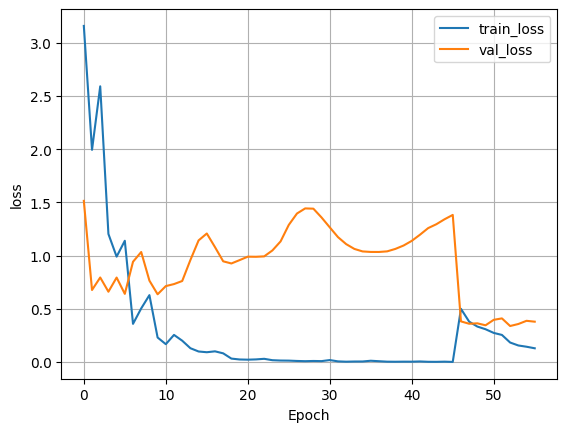

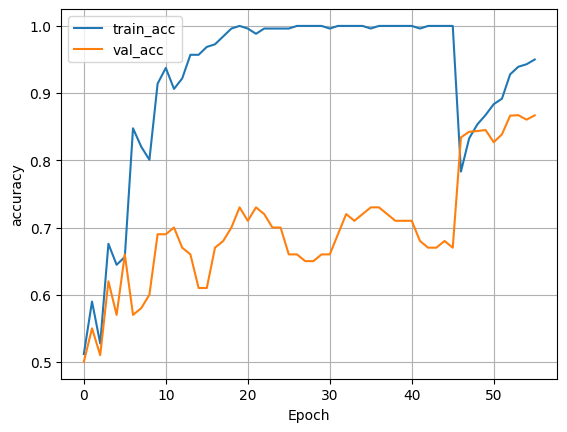

In [3]:
plot_csv_logger(r'C:\Users\fardin\Projects\ColorIntelligence\logs\GcnGatSentiment3\version_4\metrics.csv')

In [27]:
trainer.checkpoint_callback.best_model_path

'logs/GcnGatSentiment3\\version_4\\checkpoints\\epoch=53-step=2148.ckpt'

In [ ]:
# trainer.save_checkpoint('example.ckpt')
BinaryLightningModel.load_from_checkpoint(checkpoint_path='example.ckpt', model=torch_model)

In [ ]:
lightning_model.eval()
with torch.inference_mode():
    logits = lightning_model('new_data')

In [ ]:
trainer.test(model=lightning_model, datamodule=data_manager, ckpt_path='best')

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import summary
from tqdm import tqdm
from Scripts.Models.LightningModels.LightningModels import BaseLightningModel
from Scripts.Models.ModelsManager.ModelManager import ModelManager
from Scripts.Models.BaseModels.GATGCNClassifierSimple import GNNClassifier
from Scripts.DataManager.GraphLoader.NLabeledGraphLoader import NLabeledGraphLoader
from Scripts.Utils.enums import Optimizer, LossType

import lightning as L


class SimpleNodeClassifierModelManager(ModelManager):

    def __init__(self, graph_handler: NLabeledGraphLoader, device=torch.device('cpu'),
                 lr=0.01, weight_decay=0.001, optimizer_type: Optimizer = Optimizer.ADAM,
                 loss_type: LossType = LossType.CROSS_ENTROPY):
        super(SimpleNodeClassifierModelManager, self).__init__(lr, weight_decay, device)
        self.graph_handler = graph_handler
        self.num_output_classes = self.graph_handler.num_classes
        self.num_input_features = self.graph_handler.num_features
        self.loss_type = loss_type
        self.optimizer_type = optimizer_type
        self.model, self.optimizer, self.loss_func = self._create_model(lr, weight_decay, optimizer_type, loss_type)
        self.lightning_model = BaseLightningModel(self.model, self.optimizer, self.loss_func)

    def train(self, epoch_num: int = 100, lr: float = None, l2_norm: float = None, optimizer: Optimizer = None):

        trainer = L.Trainer(max_epochs=100, accelerator='gpu', devices=1)
        trainer.fit(self.lightning_model,
                    train_dataloaders=self.graph_handler.get_train_data(),
                    val_dataloaders=self.graph_handler.get_val_data()
                    )



        if lr or l2_norm or optimizer:
            self.set_optimizer(lr, l2_norm, optimizer)

        train_losses = []
        train_accuracies = []
        test_losses = []
        test_accuracies = []

        train_node_x, train_node_y, train_edges = self.graph_handler.get_train_data()
        test_node_x, test_node_y, test_edges = self.graph_handler.get_test_data()
        for i in tqdm(range(epoch_num)):
            self.model.train()
            self.optimizer.zero_grad()
            my_node, my_label, my_edges = self.graph_handler.extract_random_sub_edges_graph()
            y_hat: torch.Tensor = self.model(my_node, my_edges)
            loss = self.loss_func(F.one_hot(my_label, self.num_output_classes).float(), y_hat)
            loss.backward()
            self.optimizer.step()

            self.model.eval()

            loss_value = loss.item()
            train_losses.append(loss_value)
            accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float()) / len(my_label)).cpu().numpy()
            train_accuracies.append(accuracy)

            my_node, my_label, my_edges = self.graph_handler.extract_random_sub_edges_graph()
            y_hat: torch.Tensor = self.model(my_node, my_edges)
            loss = self.loss_func(F.one_hot(my_label, self.graph_handler.num_classes).float(), y_hat)
            loss_value = loss.item()
            test_losses.append(loss_value)
            accuracy = (torch.sum((y_hat.argmax(dim=1) == my_label).float()) / len(my_label)).cpu().numpy()
            test_accuracies.append(accuracy)
        self.history['train_losses'] = train_losses
        self.history['train_accuracies'] = train_accuracies
        self.history['test_losses'] = test_losses
        self.history['test_accuracies'] = test_accuracies
        return self.history

    def evaluate(self):
        node_x, node_y, edges = self.graph_handler.get_val_data()
        self.model.eval()
        y_hat: torch.Tensor = self.model(node_x, edges)
        loss = self.loss_func(F.one_hot(node_y, self.num_output_classes).float(), y_hat)
        return y_hat, loss

    def predict(self, node_x, edge_index):
        self.model.eval()
        y_hat: torch.Tensor = self.model(node_x, edge_index)
        return y_hat

    def draw_summary(self):
        nodes_x, nodes_y, edge_indices_test = self.graph_handler.get_test_data()
        nodes_x, nodes_y, edge_indices_test = self.graph_handler.extract_random_sub_edges_graph(2)
        print(summary(self.model, nodes_x, edge_indices_test))

    def _create_model(self, lr, l2_norm, optimizer_type, loss_type):
        model = GNNClassifier(input_feature=self.num_input_features, class_counts=self.num_output_classes)
        optimizer = ModelManager._create_optimizer(model, lr, l2_norm, optimizer_type)
        loss_func = ModelManager._create_loss_func(loss_type)
        model.to(self.device)
        return model, optimizer, loss_func

    def set_optimizer(self, lr, l2_norm, optimizer=Optimizer.ADAM):
        if lr:
            self.lr = lr
        if l2_norm:
            self.l2_norm = l2_norm
        if optimizer:
            self.optimizer_type = optimizer
        self.optimizer = ModelManager._create_optimizer(self.model, self.lr, self.l2_norm, self.optimizer_type)


In [ ]:
# from Scripts.Models.ModelsManager.SimpleGraphClassifierModelManager import SimpleGraphClassifierModelManager

if 'Train Data':
    model_manager = SimpleGraphClassifierModelManager(
        data_manager.graph_constructors[TextGraphType.CO_OCCURRENCE])
    model_manager.draw_summary()
    model_manager.train()
    model_manager.draw_training_results()

# Draw Results

In [ ]:
from Scripts.Models.BaseModels.GcnGatModel1 import GcnGatModel1
from transformers.models.longformer.convert_longformer_original_pytorch_lightning_to_pytorch import LightningModel
mymodel = GcnGatModel1(100, 10, config)
print(type(mymodel))
model = LightningModel(mymodel)
print(type(model))

In [ ]:
from typing import Tuple


def sample_func() -> Tuple[int, float]:
    return 1, 2.5

In [ ]:
targets = sample_func

In [ ]:
type(targets)

In [ ]:
from Scripts.Utils.enums import Optimizer

type(Optimizer.ADAM)

In [ ]:
def sample_func():
    return True

In [ ]:
from typing import Callable
import types

In [ ]:
aa: Callable = None
type(aa)